# Lab 6
### Daniel Mehta

## Apply all techniques you learned this week to train an LSTM and Bidirectional LSTM network on the "Frankenstein" dataset(Please download the dataset from Kaggle).

# Load Data

In [5]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

2025-07-09 16:50:08.831294: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
df = pd.read_csv("ZC.csv")

In [7]:
print("Shape of dataset:", df.shape)
print("\nColumn names:", df.columns.tolist())

Shape of dataset: (86, 2)

Column names: ['name', 'line']


In [8]:
df.head()

,name,line
0,Human,Human is the most dangerous race
1,Human,We rule the world
2,Human,Time to go to work
3,Human,Where are you from?))))
4,Human,Roadtrip!


# Extract Samples

In [10]:
# extract line column
lines =df['line'].astype(str).tolist()

In [11]:
# initiate tokenizer at word level
tokenizer =Tokenizer()
tokenizer.fit_on_texts(lines)

In [12]:
# generate input output sequence pairs
sequences = []
for line in lines:
    token_list =tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_seq = token_list[:i+1]
        sequences.append(n_gram_seq)

In [13]:
# pad sequences
max_seq_len=max(len(seq) for seq in sequences)
sequences = pad_sequences(sequences, maxlen=max_seq_len,padding='pre')

In [14]:
#split into input (X) and label (y)
sequences = np.array(sequences)
X =sequences[:, :-1] # input sequence
y =sequences[:, -1] # target (next word)

In [15]:
# One hot encode labels
vocab_size = len(tokenizer.word_index) +1
y = tf.keras.utils.to_categorical(y,num_classes=vocab_size)

In [16]:
print("X.shape:", X.shape)
print("y.shape:", y.shape)

X.shape: (370, 14)
y.shape: (370, 224)


# Train Test split

In [18]:
# 90 / 10 split
train_data, test_data, train_labels, test_labels = train_test_split(X, y,test_size=0.1,random_state=5500)

In [19]:
# Adding 3rd dimension
train_data = np.expand_dims(train_data, axis=-1)
test_data = np.expand_dims(test_data, axis=-1)

---

# LSTM

## Create Model (LSTM)

In [22]:
i = Input(shape=(train_data[0].shape[0], 1)) # Input shape
x = LSTM(128)(i) # 128 LSTM units
x = Dense(vocab_size, activation='softmax')(x) #Predict next word
model = Model(i, x)

## Complie the model

In [24]:
model.compile(optimizer=Adam(learning_rate=0.001), # adaptave 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Train

In [26]:
# Train Model
hist = model.fit(train_data, train_labels,
                 validation_data=(test_data, test_labels),
                 epochs=50)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.0081 - loss: 5.4045 - val_accuracy: 0.0000e+00 - val_loss: 5.3388
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0304 - loss: 5.2111 - val_accuracy: 0.0000e+00 - val_loss: 5.3597
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0505 - loss: 5.0595 - val_accuracy: 0.0000e+00 - val_loss: 5.4138
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0559 - loss: 4.9003 - val_accuracy: 0.0270 - val_loss: 5.5292
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0596 - loss: 4.6942 - val_accuracy: 0.0270 - val_loss: 5.7719
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0712 - loss: 4.6157 - val_accuracy: 0.0270 - val_loss: 5.8215
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0677 - loss: 4.3761 - val_accuracy: 0.0541 - val_loss: 5.9802
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0789 - loss: 4.4146 - val_accuracy

## Plot

In [28]:
trainAcc = [100 * x for x in hist.history['accuracy']]
testAcc = [100 * x for x in hist.history['val_accuracy']]

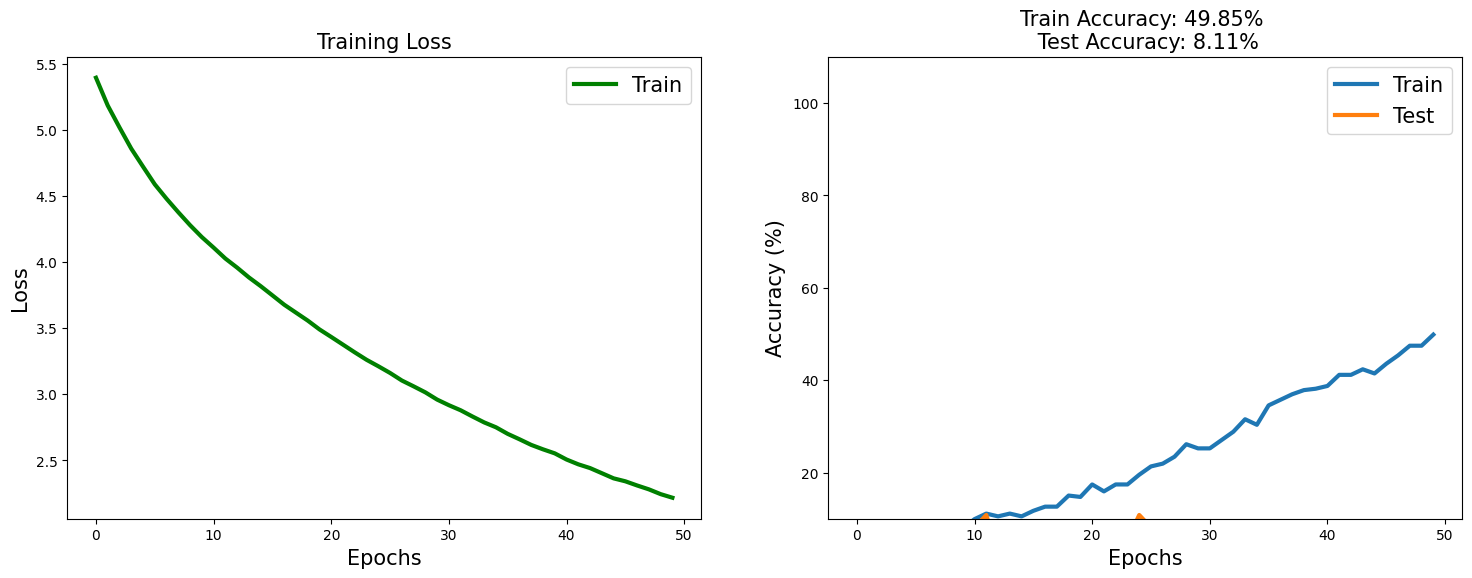

In [29]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

# Loss plot
ax[0].plot(hist.history['loss'], 'g', lw = 3, label = 'Train')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)

# Accuracy plot
ax[1].plot(trainAcc, label ='Train', lw = 3)
ax[1].plot(testAcc, label ='Test', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()

---

# Bidirectional LSTM

## Create the Model

In [32]:
i = Input(shape=(train_data.shape[1], 1)) #shape = (timesteps, features)
x = Bidirectional(LSTM(128))(i)
x = Dense(vocab_size, activation='softmax')(x)
model_bi = Model(i, x)

## Compile

In [34]:
model_bi.compile(optimizer=Adam(learning_rate=0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

## Train

In [36]:
hist_bi = model_bi.fit(train_data, train_labels,
                       validation_data=(test_data, test_labels),
                       epochs=50)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 7.6092e-04 - loss: 5.4236 - val_accuracy: 0.0270 - val_loss: 5.4406
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0487 - loss: 5.1533 - val_accuracy: 0.0270 - val_loss: 5.4892
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0447 - loss: 4.8364 - val_accuracy: 0.0270 - val_loss: 5.7442
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0542 - loss: 4.7444 - val_accuracy: 0.0270 - val_loss: 5.8342
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0607 - loss: 4.6647 - val_accuracy: 0.0270 - val_loss: 6.0166
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0665 - loss: 4.4977 - val_accuracy: 0.0000e+00 - val_loss: 6.2429
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0747 - loss: 4.3376 - val_accuracy: 0.0000e+00 - val_loss: 6.4208
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0741 - loss: 4.1734 - val_accuracy

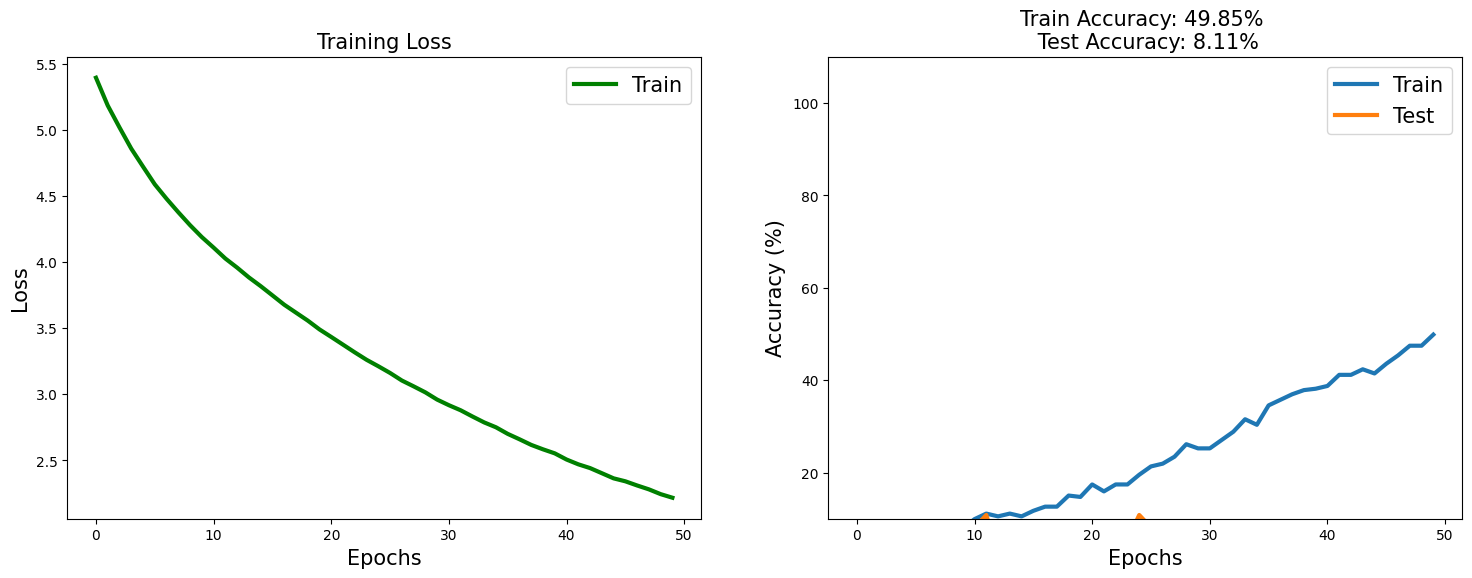

In [37]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

# Loss plot
ax[0].plot(hist.history['loss'], 'g', lw = 3, label = 'Train')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)

# Accuracy plot
ax[1].plot(trainAcc, label ='Train', lw = 3)
ax[1].plot(testAcc, label ='Test', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()

---

# Post Running Notes

- Both models were trained on a small "Frankenstein" dataset (86 English lines)
- Training accuracy improved over time, showing that the models were learning patterns
- Test accuracy remained low, likely due to a small dataset size
- Bidirectional LSTM did not outperform the regular LSTM and Train and Test Accuracy are the same